In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pysentani import *
import sentani as sti
survey = find_survey("../data-anonymous")

../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx


In [22]:
survey['access_type'] = survey['village_name'].apply(lambda x: sti.access_map.get(x))

In [40]:
frequency = {'genset_expenditure':'daily'}

multiplier = {'daily':30}

# create new columns with same monthly frequency
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure



pd.set_option('max_rows', 200)
survey.groupby(['access_type'])[['genset_expenditure_monthly']].agg(['sum','count'])

genset_expenditure_monthly      
                                           sum count
access_type                                         
PLN_grid                              17850000     3
PLN_microgrid                         63600000    57
community_microgrid                    4500000     1
no_access                            202170120   178

In [26]:
#monthly expenditure divided by 960 rp per kWh (.08 USD per kWh * 12000 rp to USD exchange)
def genset_kwh_conversion(df):
    converted = (df['genset_expenditure_monthly']/(960))
    return converted

survey['genset_kWh'] = survey.apply(genset_kwh_conversion, axis=1)

# kWh multiplied by Lawrence Berkely Labratory estimation of 1100 g CO2 per kWh
def CO2_emission(df1):
    converted = df1['genset_kWh']*1100 
    return converted

survey['CO2_g'] = survey.apply(CO2_emission, axis=1)

# Potential Photovoltaic carbon emissions (g CO2 per kWh), (if genset replaced by PV)
def PV_emission(df2):
    converted = df2['genset_kWh']*100
    return converted
survey['PV_emission'] = survey.apply(PV_emission, axis=1)

# CO2 reduction (co2(g) column - PV_emission column)

def CO2_reduction(df3):
    converted = df3['CO2_g']-survey['PV_emission']
    return converted
survey['CO2_reduction'] = survey.apply(CO2_reduction, axis=1)

In [102]:
vnat_dict = survey.set_index('village_name')['access_type'].to_dict()
vnat_series = list(vnat_dict.values())
vnat_key_ls = list(vnat_dict.keys())

df4_dict = {'village_name': vnat_key_ls,
            'access_type':vnat_series,
            'CO2_g': df['CO2_g'],
            'PV_emission': df['PV_emission'],
            'CO2_reduction': df['CO2_reduction']}

df4 = pd.DataFrame(df4_dict)

In [28]:
df4

CO2_g  CO2_reduction  PV_emission  \
access_type         village_name                                           
PLN_grid            Ajau                 NaN            NaN          NaN   
                    Asei                 NaN            NaN          NaN   
                    Babrongko            NaN            NaN          NaN   
                    Burawai              NaN            NaN          NaN   
                    Evale                NaN            NaN          NaN   
                    Flafow               NaN            NaN          NaN   
                    Hobong        17187500.0     17031250.0    1562500.0   
                    Khamayakha     3265625.0      2953125.0     296875.0   
                    Kheleubulow          NaN            NaN          NaN   
                    Kwadeware            NaN            NaN          NaN   
                    Pantai_Yahim         NaN            NaN          NaN   
                    Simporo              NaN            NaN          NaN   
                    Sosiri               NaN            NaN          NaN   
                    Yakonde              NaN            NaN          NaN   
                    Yobeh                NaN            NaN          NaN   
                    Yoka                 NaN            NaN          NaN   
PLN_microgrid       Ayapo         72875000.0     63968750.0    6625000.0   
                    Donday               NaN            NaN          NaN   
community_microgrid Atamali        5156250.0      5000000.0     468750.0   
                    Kensio               NaN            NaN          NaN   
no_access           Abar          23375000.0     20718750.0    2125000.0   
                    Ebunfauw      30593750.0     26375000.0    2781250.0   
                    Kalio         15812500.0     13937500.0    1437500.0   
                    Kampung_Baru  39600000.0     35381250.0    3600000.0   
                    Khageuw        9625000.0      8375000.0     875000.0   
                    Obolyo               NaN            NaN          NaN   
                    Puai          68303125.0     61740625.0    6209375.0   
                    Yoboi         23375137.5     18843887.5    2125012.5   
                    Yokiwa        20968750.0     18468750.0    1906250.0   

                                          access_type  village_name  
access_type         village_name                                     
PLN_grid            Ajau                     PLN_grid          Yoka  
                    Asei                PLN_microgrid         Ayapo  
                    Babrongko                PLN_grid       Simporo  
                    Burawai                  PLN_grid    Khamayakha  
                    Evale                   no_access         Yoboi  
                    Flafow                  no_access          Abar  
                    Hobong                   PLN_grid        Sosiri  
                    Khamayakha              no_access         Kalio  
                    Kheleubulow              PLN_grid          Ajau  
                    Kwadeware                PLN_grid       Burawai  
                    Pantai_Yahim            no_access      Ebunfauw  
                    Simporo                 no_access       Khageuw  
                    Sosiri                   PLN_grid        Hobong  
                    Yakonde       community_microgrid        Kensio  
                    Yobeh                    PLN_grid     Kwadeware  
                    Yoka                PLN_microgrid        Donday  
PLN_microgrid       Ayapo                   no_access        Yokiwa  
                    Donday        community_microgrid       Atamali  
community_microgrid Atamali                  PLN_grid   Kheleubulow  
                    Kensio                   PLN_grid        Flafow  
no_access           Abar                     PLN_grid         Yobeh  
                    Ebunfauw                 PLN_grid         Evale  
  

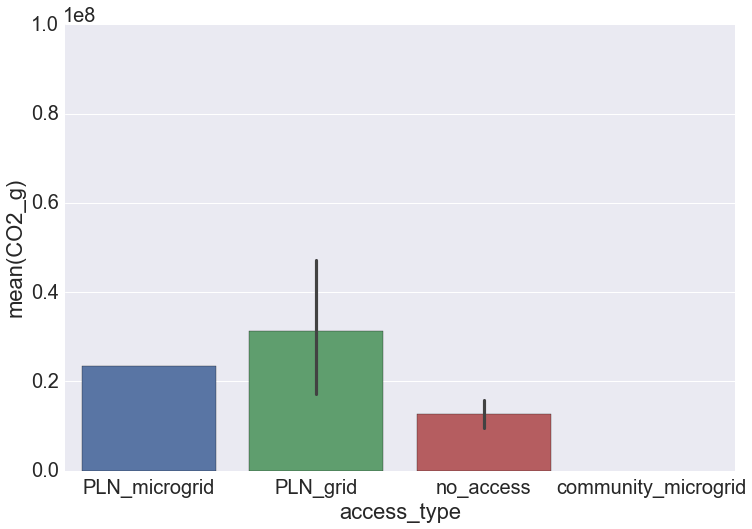

In [108]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="access_type", y='CO2_g', data=df4)

plt.ylim(0,1e8)
locs, labels = plt.xticks()

###This graph represents g/kWh of CO2 emmisions currently produced by diesel generators in Lake Sentani.

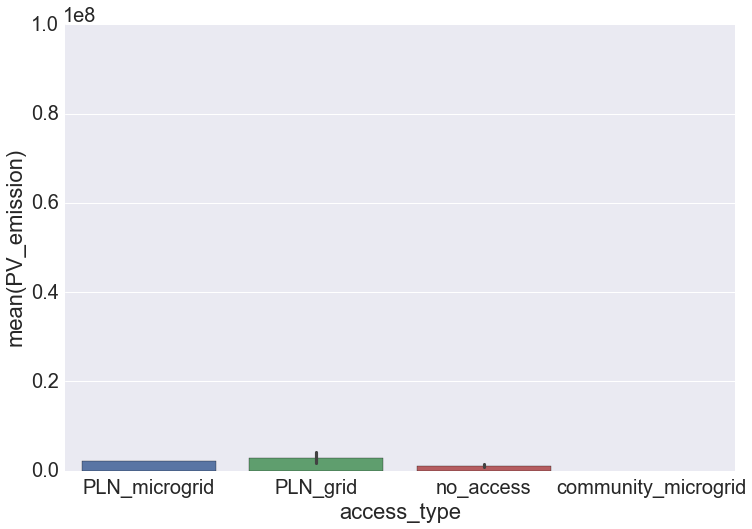

In [110]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="access_type", y='PV_emission', data=df4)


plt.ylim(0,1e8)
locs, labels = plt.xticks()
## This graph represents the total g CO2/kWh if generators are replaced with Photovoltaic Microgrids.